# -----import package-----

In [140]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import linemerge
from shapely.wkt import loads
from shapely.geometry import LineString
from shapely.geometry import Point, Polygon
from scipy.spatial import Delaunay

# -----point file-----

In [45]:
df_point = gpd.read_file('hydrant_location/hydrant_location.shp')

In [48]:
df_point['id'] = df_point.reset_index().index

In [49]:
df_point

,id,geometry
0,0,POINT (-74.00698 40.74748)
1,1,POINT (-74.00722 40.74722)
2,2,POINT (-74.00721 40.74697)
3,3,POINT (-74.00722 40.74722)
4,4,POINT (-74.00728 40.74667)
...,...,...
2295,2295,POINT (-73.97976 40.71559)
2296,2296,POINT (-73.97987 40.71361)
2297,2297,POINT (-73.98387 40.72077)
2298,2298,POINT (-73.97780 40.71833)


# -----road file-----

In [17]:
df_road = gpd.read_file('road_location/road_location.shp')

In [19]:
df_road.drop('road_id', axis=1, inplace=True)

In [36]:
df_road

,id,geometry
0,1,"LINESTRING (-74.01301 40.70215, -74.01167 40.7..."
1,1,"LINESTRING (-74.01171 40.70247, -74.00999 40.7..."
2,1,"LINESTRING (-74.00577 40.70566, -74.00396 40.7..."
3,1,"LINESTRING (-74.00385 40.70651, -74.00142 40.7..."
4,2,"LINESTRING (-74.01270 40.70275, -74.01180 40.7..."
...,...,...
331,248,"LINESTRING (-73.99741 40.72164, -73.99389 40.7..."
332,249,"LINESTRING (-74.00203 40.71159, -74.00252 40.7..."
333,250,"LINESTRING (-74.00296 40.71334, -74.00150 40.7..."
334,251,"LINESTRING (-74.00799 40.70899, -74.00720 40.7..."


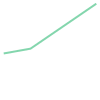

In [35]:
df_road.iloc[1][1]

# -----calculate distance between road and point-----

In [70]:
def find_closest_road(point, roads_df):
    min_distance = float('inf')
    closest_road_id = None

    for idx, road in roads_df.iterrows():
        distance = point.distance(road['geometry'])
        if distance < min_distance:
            min_distance = distance
            closest_road_id = road['id']

    return closest_road_id

In [72]:
df_point['closest_road_id'] = df_point.apply(lambda row: find_closest_road(row['geometry'], df_road), axis=1)

In [75]:
df_point.drop('Closest_Road_ID', axis=1, inplace=True)

In [76]:
df_point

,id,geometry,closest_road_id
0,0,POINT (-74.00698 40.74748),119
1,1,POINT (-74.00722 40.74722),119
2,2,POINT (-74.00721 40.74697),120
3,3,POINT (-74.00722 40.74722),119
4,4,POINT (-74.00728 40.74667),120
...,...,...,...
2295,2295,POINT (-73.97976 40.71559),234
2296,2296,POINT (-73.97987 40.71361),30
2297,2297,POINT (-73.98387 40.72077),221
2298,2298,POINT (-73.97780 40.71833),199


# -----block file-----

In [141]:
def blockInfo(shapefile):
    gdf = gpd.read_file(shapefile)
    block_info_list = []
    for idx, row in gdf.iterrows():
        block_id = row['id'] 
        polygon = row['geometry'] 
        corners = list(polygon.exterior.coords)
        block_info = {
            'blockID': block_id,
            'corners': corners
        }
        block_info_list.append(block_info)
    return block_info_list

In [142]:
def blockIdentify(hydrantCenter, blocks):
    hydrantPoint = Point(hydrantCenter)
    for block in blocks:
        blockCoords = block['corners'] 
        blockPolygon = Polygon(blockCoords)
        if hydrantPoint.within(blockPolygon):
            hydrantBlockID = block['blockID'] 
            return hydrantBlockID
    return None

In [145]:
blocks = blockInfo("block_location/blocksagain.shp")
df_point['block_id'] = df_point.apply(lambda row: blockIdentify(row['geometry'], blocks), axis=1)

In [149]:
# Check if the entire dataframe contains NA values
is_na_anywhere = df_point.isna().any().any()

print("Dataframe contains NA values:", is_na_anywhere)

Dataframe contains NA values: True


In [150]:
df_point.drop('block', axis=1, inplace=True)

In [151]:
df_point

,id,geometry,closest_road_id,block_id
0,0,POINT (-74.00698 40.74748),119,1.0
1,1,POINT (-74.00722 40.74722),119,2.0
2,2,POINT (-74.00721 40.74697),120,2.0
3,3,POINT (-74.00722 40.74722),119,2.0
4,4,POINT (-74.00728 40.74667),120,3.0
...,...,...,...,...
2295,2295,POINT (-73.97976 40.71559),234,505.0
2296,2296,POINT (-73.97987 40.71361),30,901.0
2297,2297,POINT (-73.98387 40.72077),221,437.0
2298,2298,POINT (-73.97780 40.71833),199,444.0


# -----Hydrant Class-----

In [83]:
class Hydrant:
    
    def __init__(self, id, x, y, closest_road_id): # constructor
        
        # From shapefile
        self.pointID = id
        self.x = x
        self.y = y
        self.blockID = 0
        self.roadID = closest_road_id
        
        # Will initialize once into network generation
        self.branchID = 0
        self.neighbor = [] # List to store all the neighbors of this hydrant
        self.edge = {} # Dict to store edge information

# -----convert the above dataframe to hydrant object-----

In [84]:
# Create an empty list to store the 'hydrant' instances
hydrant_instances = []

# Iterate through each row in the DataFrame and create 'hydrant' instances
for index, row in df_point.iterrows():
    # Get the Point object from the 'geometry' column
    point = row['geometry']
    
    # Extract 'x' and 'y' coordinates from the Point object
    x, y = point.x, point.y
    
    # Create 'hydrant' instance and add it to the list
    hydrant_obj = Hydrant(row['id'], x, y, row['closest_road_id'])
    hydrant_instances.append(hydrant_obj)

In [87]:
print(hydrant_instances[0].pointID)
print(hydrant_instances[0].x)
print(hydrant_instances[0].y)
print(hydrant_instances[0].roadID)

0
-74.00697762006345
40.74747950102119
119


# -----Delaunay Triangulation-----

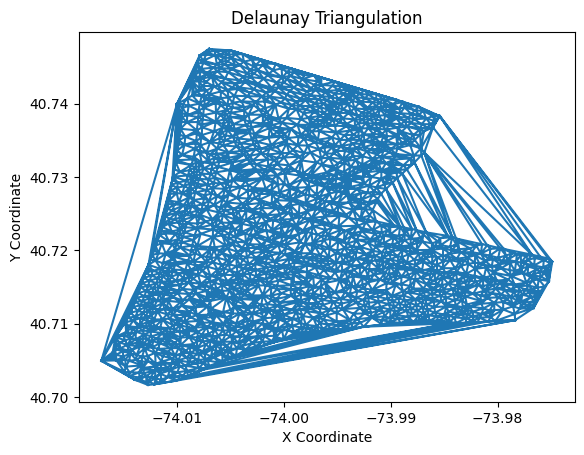

In [163]:
# Create a list of points with (x, y) coordinates and corresponding 'id' as a tuple
points = [(hydrant.x, hydrant.y, hydrant.pointID) for hydrant in hydrant_instances]

# Perform Delaunay triangulation
triangulation = Delaunay(np.array([(point[0], point[1]) for point in points]))

# Plot the triangulation (optional)
plt.triplot(np.array(points)[:, 0], np.array(points)[:, 1], triangulation.simplices)
#plt.plot(np.array(points)[:, 0], np.array(points)[:, 1], 'o')

'''
# Annotate each point with its 'id'
for point in points:
    plt.text(point[0], point[1], str(point[2]), ha='center', va='bottom')
'''
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Delaunay Triangulation')
plt.show()

In [164]:
for simplex in triangulation.simplices:
    triangle_ids = [points[index][2] for index in simplex]
    print("Triangle IDs:", triangle_ids)

Triangle IDs: [293, 140, 409]
Triangle IDs: [293, 312, 304]
Triangle IDs: [312, 307, 304]
Triangle IDs: [296, 307, 302]
Triangle IDs: [307, 296, 304]
Triangle IDs: [294, 293, 304]
Triangle IDs: [294, 296, 293]
Triangle IDs: [1963, 1958, 1956]
Triangle IDs: [1964, 1958, 1963]
Triangle IDs: [61, 2002, 2003]
Triangle IDs: [2006, 2002, 61]
Triangle IDs: [444, 440, 437]
Triangle IDs: [408, 407, 409]
Triangle IDs: [296, 295, 304]
Triangle IDs: [295, 294, 304]
Triangle IDs: [294, 295, 296]
Triangle IDs: [996, 1312, 1301]
Triangle IDs: [995, 996, 1301]
Triangle IDs: [194, 192, 140]
Triangle IDs: [25, 52, 13]
Triangle IDs: [25, 32, 52]
Triangle IDs: [32, 25, 27]
Triangle IDs: [175, 172, 140]
Triangle IDs: [172, 169, 140]
Triangle IDs: [165, 160, 140]
Triangle IDs: [169, 165, 140]
Triangle IDs: [150, 148, 140]
Triangle IDs: [6, 13, 0]
Triangle IDs: [6, 12, 13]
Triangle IDs: [1980, 1979, 1956]
Triangle IDs: [1979, 1963, 1956]
Triangle IDs: [1981, 1979, 1980]
Triangle IDs: [1979, 1981, 1977]
Trian

# -----Filter out edges that exceed the maximum-----

# -----Filter out edge in the same block-----

In [171]:
# Function to calculate the Euclidean distance between two points
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [172]:
# Threshold for maximum allowed edge length
max_edge_length = 0.002

In [173]:
# Set to store filtered edges (edges that don't exceed the maximum length)
filtered_edges = set()

In [174]:
# Loop through each triangle (simplex)
for simplex in triangulation.simplices:
    # Get the indices of the points forming the edges of the triangle
    edge1 = frozenset([simplex[0], simplex[1]])
    edge2 = frozenset([simplex[1], simplex[2]])
    edge3 = frozenset([simplex[0], simplex[2]])

    # Get the actual points from the 'points' list using the indices
    point1, point2, point3 = points[simplex[0]], points[simplex[1]], points[simplex[2]]

    # Calculate the lengths of the edges
    edge_lengths = [distance(point1, point2), distance(point2, point3), distance(point1, point3)]

    # debug
    print(df_point.at[simplex[0], 'block_id'], df_point.at[simplex[1], 'block_id'], df_point.at[simplex[2], 'block_id'])
    
    # Check if any edge length exceeds the maximum allowed length
    # If any edge length exceeds the limit, remove the corresponding edges from the set
    if distance(point1, point2) <= max_edge_length and (df_point.at[simplex[0], 'block_id'] != df_point.at[simplex[1], 'block_id']):
        print('add edge 1')
        filtered_edges.add(edge1)
    if distance(point2, point3) <= max_edge_length and (df_point.at[simplex[1], 'block_id'] != df_point.at[simplex[2], 'block_id']):
        print('add edge 2')
        filtered_edges.add(edge2)
    if distance(point1, point3) <= max_edge_length and (df_point.at[simplex[0], 'block_id'] != df_point.at[simplex[2], 'block_id']):
        print('add edge 3')
        filtered_edges.add(edge3)

nan nan nan
nan nan nan
add edge 1
add edge 2
add edge 3
nan 622.0 nan
add edge 1
add edge 2
add edge 3
620.0 622.0 620.0
add edge 1
add edge 2
622.0 620.0 nan
add edge 1
add edge 2
add edge 3
nan nan nan
add edge 1
add edge 2
add edge 3
nan 620.0 nan
add edge 1
add edge 2
add edge 3
509.0 532.0 878.0
add edge 1
add edge 2
add edge 3
532.0 532.0 509.0
add edge 2
add edge 3
97.0 nan 447.0
add edge 2
nan nan 97.0
add edge 1
738.0 737.0 nan
add edge 1
add edge 2
724.0 724.0 nan
add edge 2
add edge 3
620.0 nan nan
add edge 1
add edge 2
add edge 3
nan nan nan
add edge 1
add edge 2
add edge 3
nan nan 620.0
add edge 1
add edge 2
add edge 3
336.0 347.0 347.0
add edge 1
add edge 3
336.0 336.0 347.0
add edge 2
add edge 3
nan nan nan
add edge 1
nan nan nan
nan nan nan
nan nan nan
add edge 2
nan nan nan
add edge 1
nan nan nan
add edge 1
nan nan nan
add edge 1
nan nan nan
add edge 1
nan nan nan
add edge 1
add edge 2
add edge 3
1.0 nan 1.0
add edge 1
1.0 1.0 nan
add edge 2
add edge 3
488.0 488.0 878

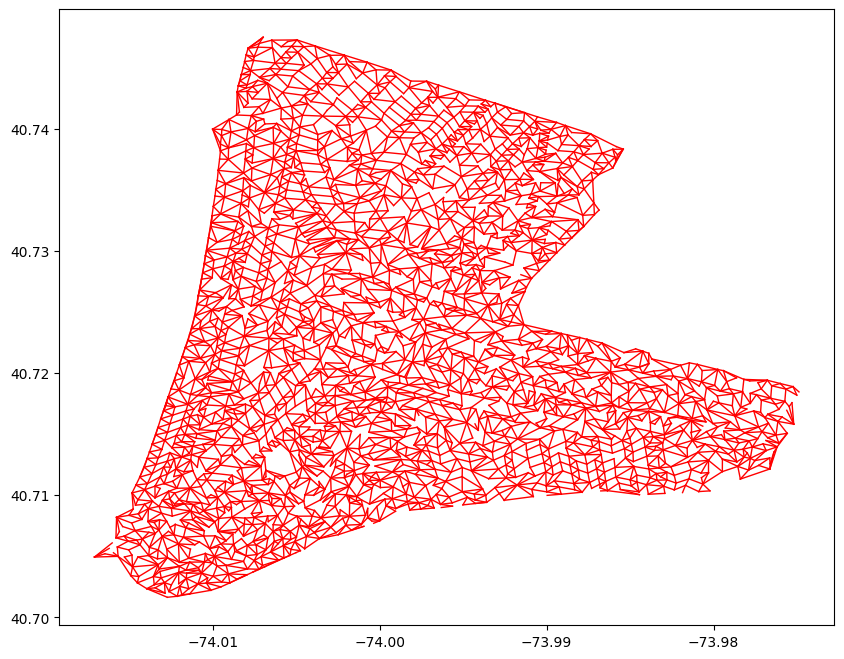

In [176]:
# Plot the filtered edges
plt.figure(figsize=(10, 8))
for edge in filtered_edges:
    edge_points = list(edge)
    plt.plot(np.array(points)[edge_points, 0], np.array(points)[edge_points, 1], 'r-', linewidth=1)
plt.savefig('filtered_edges_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [177]:
# -----Create a GeoDataFrame for filtered edges-----

# Create a list of LineString objects for filtered edges
lines = []
for edge in filtered_edges:
    edge_points = list(edge)
    line = LineString(np.array(points)[edge_points])
    lines.append(line)

# Create a GeoDataFrame from the LineString objects
gdf_filtered_edges = gpd.GeoDataFrame(geometry=lines)

# Save the GeoDataFrame as a shapefile
gdf_filtered_edges.to_file('filtered_edges.shp')

# -----not exclude in block (as comparison)-----

In [185]:
# Set to store filtered edges (edges that don't exceed the maximum length)
filtered_edges_cp = set()

In [187]:
# Loop through each triangle (simplex)
for simplex in triangulation.simplices:
    # Get the indices of the points forming the edges of the triangle
    edge1 = frozenset([simplex[0], simplex[1]])
    edge2 = frozenset([simplex[1], simplex[2]])
    edge3 = frozenset([simplex[0], simplex[2]])

    # Get the actual points from the 'points' list using the indices
    point1, point2, point3 = points[simplex[0]], points[simplex[1]], points[simplex[2]]

    # Calculate the lengths of the edges
    edge_lengths = [distance(point1, point2), distance(point2, point3), distance(point1, point3)]
    
    # Check if any edge length exceeds the maximum allowed length
    # If any edge length exceeds the limit, remove the corresponding edges from the set
    if distance(point1, point2) <= max_edge_length:
        filtered_edges_cp.add(edge1)
    if distance(point2, point3) <= max_edge_length:
        filtered_edges_cp.add(edge2)
    if distance(point1, point3) <= max_edge_length:
        filtered_edges_cp.add(edge3)

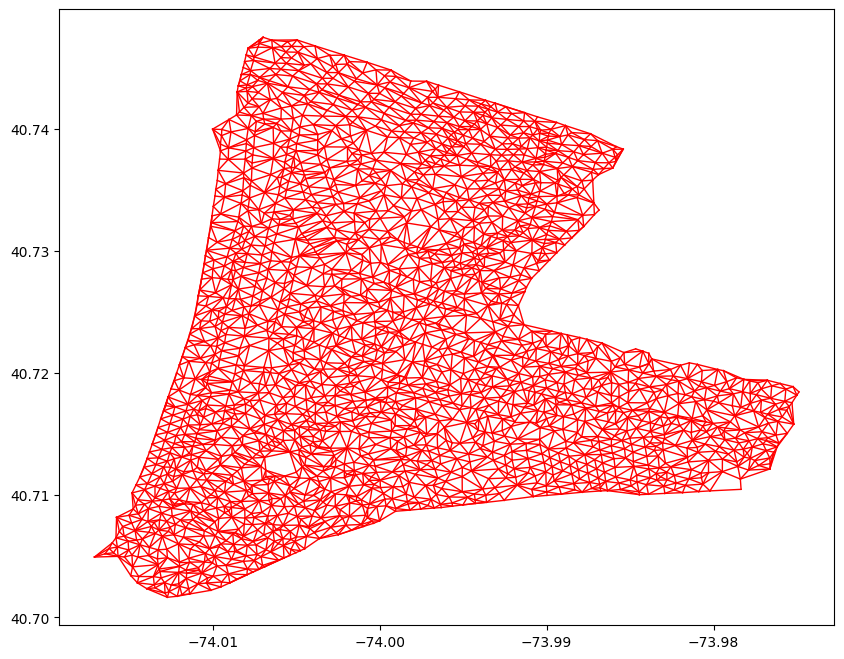

In [188]:
# Plot the filtered edges
plt.figure(figsize=(10, 8))
for edge in filtered_edges_cp:
    edge_points = list(edge)
    plt.plot(np.array(points)[edge_points, 0], np.array(points)[edge_points, 1], 'r-', linewidth=1)

In [189]:
# -----Create a GeoDataFrame for filtered edges-----

# Create a list of LineString objects for filtered edges
lines = []
for edge in filtered_edges_cp:
    edge_points = list(edge)
    line = LineString(np.array(points)[edge_points])
    lines.append(line)

# Create a GeoDataFrame from the LineString objects
gdf_filtered_edges_cp = gpd.GeoDataFrame(geometry=lines)

# Save the GeoDataFrame as a shapefile
gdf_filtered_edges_cp.to_file('filtered_edges_cp.shp')